In [363]:
#!/usr/bin/env python3
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd


problems = ['toy', 'biased_mnist']
indep_measures = ['hsic', 'cka']

kernels = ["linear", "rbf"]

stats = {prob: {indep: {k: {} for k in kernels} for indep in indep_measures} for prob in problems}
for prob in problems:
    for indep in indep_measures:
        for k in kernels:
            root = Path(f"{prob}/{indep}/{k}_kernel")
            for lambda_dir in root.iterdir():
                results_per_run = []
                l = lambda_dir.name.split('_')[1]
                for run_dir in lambda_dir.iterdir():
                    results = run_dir / "results.json"
                    assert results.exists(), f'expected to find {results}!'

                    with open(results, "r") as f:
                        r = json.load(f)
                        results_per_run.append(r)

                cos = []
                norms = []

                for res in results_per_run:
                    if prob == 'toy':
                        net_0 = np.asarray(res["weights"]["0"]['dense/kernel:0'])
                        net_1 = np.asarray(res["weights"]["1"]['dense_2/kernel:0'])

                        norm_0 = float(np.sqrt(net_0.T @ net_0))
                        norm_1 = float(np.sqrt(net_1.T @ net_1))

                        c = (net_0.T @ net_1) / (norm_0 * norm_1)
                        assert -1 <= c and c <= 1
                        cos.append(float(c))
                        norms.append([norm_0, norm_1])
                    else:
                        w0 = np.asarray(res['weights']['0']['dense/kernel:0'])
                        w1 = np.asarray(res['weights']['1']['dense_2/kernel:0'])

                        norm_0 = float(np.linalg.norm(w0)) 
                        norm_1 = float(np.linalg.norm(w1))
                        norms.append([norm_0, norm_1])
                        
                        w0_normed = w0.T / np.linalg.norm(w0, axis=0)[:, np.newaxis]
                        w1_normed = w1.T / np.linalg.norm(w1, axis=0)[:, np.newaxis]
                         
                        c = w0_normed @ w1_normed.T
                        c = np.absolute(c)
                        assert (c <= 1).all()
                        c = c.max()
                        cos.append(c)
                        
                cur_stats = {
                    "cos": np.asarray(cos),
                    "norms": np.asarray(norms),
                }
                for m in ['test_diversity_loss', 
                          'test_prediction_loss',
                          'train_diversity_loss',
                          'train_accuracy',
                          'test_accuracy'
                         ]:
                    cur_stats[m] = np.asarray([r[m] for r in results_per_run])
                    
                stats[prob][indep][k][l] = cur_stats

print('done')

done


In [364]:
def data_for_kernel(problem: str, indep: str, k: str, column: str, swap_by_column: Optional[str] = None) -> pd.DataFrame:
    data = []
    
    for l in stats[problem][indep][k].keys():
        col = stats[problem][indep][k][l][column]

        if swap_by_column:
            swap_networks = [r[0] < r[1] for r in stats[problem][indep][k][l][swap_by_column]]
        else:
            swap_networks = [False] * len(col)
        
        for i_run, run_value in enumerate(col):
            if run_value.shape != ():
                if swap_networks[i_run]:
                    run_value = np.flip(run_value)
                
                for ix, d in enumerate(run_value):
                    data.append({
                        'lambda': float(l),
                        column: d,
                        'network': f'{ix}_{k}',
                        'kernel': k,
                    })
            else:
                data.append({
                    'lambda': float(l),
                    column: run_value,
                    'kernel': k,
                })

    return pd.DataFrame(data=data)

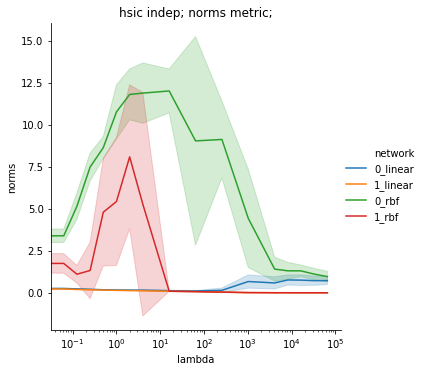

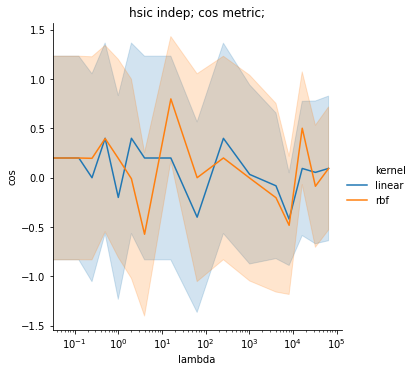

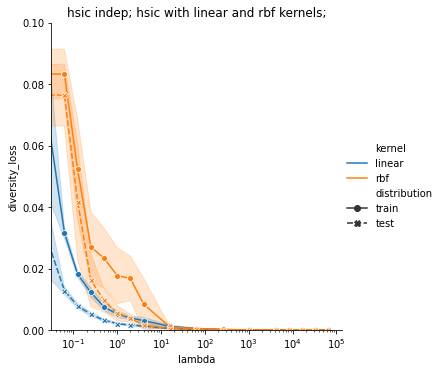

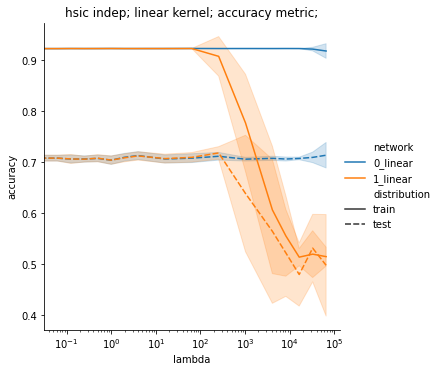

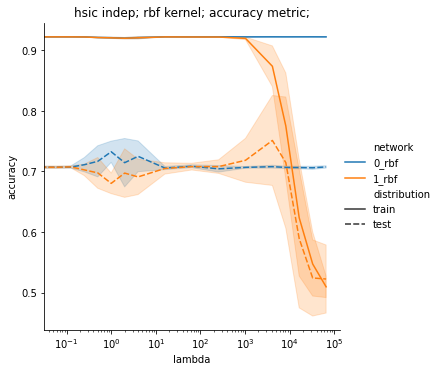

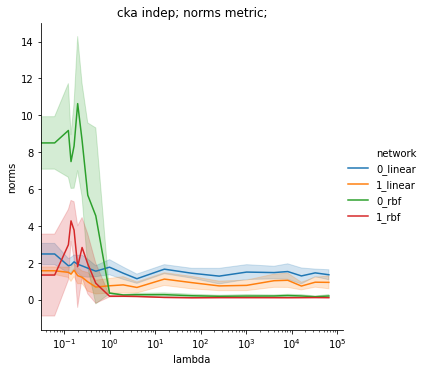

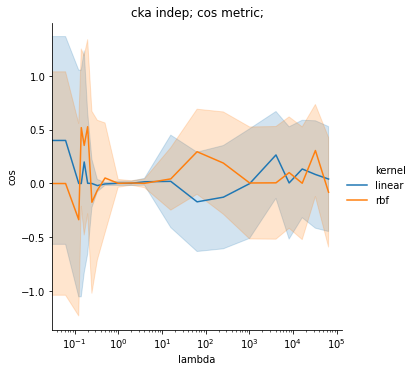

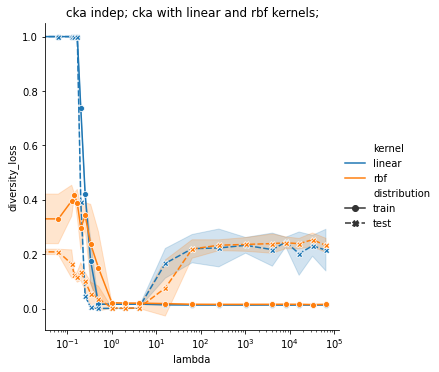

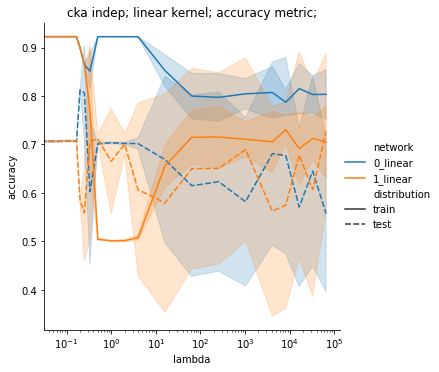

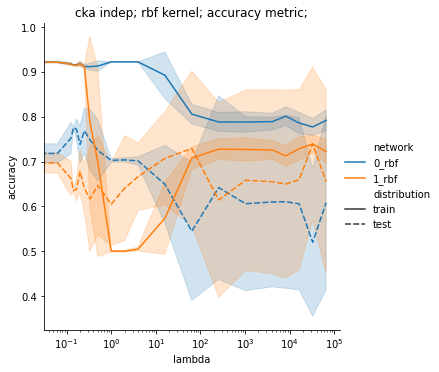

In [341]:
problem = 'toy'

os.makedirs(f'{problem}/plots', exist_ok=True)

for indep in indep_measures:  
    metric = 'norms'
    df = pd.concat([data_for_kernel(problem, indep, k, metric, swap_by_column='norms') for k in kernels])
    plot = sns.relplot(x="lambda", y=metric, ci="sd", kind="line", hue='network', data=df)
    plot.set(xscale="log")
    plot.set(title=f'{indep} indep; {metric} metric;')
    plot.savefig(f'{problem}/plots/{indep}_{metric}.png')

    
    metric = 'cos'
    df = pd.concat([data_for_kernel(problem, indep, k, metric, swap_by_column='norms') for k in kernels])
    plot = sns.relplot(x="lambda", y=metric, ci="sd", kind="line", hue='kernel', data=df)
    plot.set(xscale="log")
    plot.set(title=f'{indep} indep; {metric} metric;')
    plot.savefig(f'{problem}/plots/{indep}_{metric}.png')
    
    
    dfs = []
    for k in kernels:
        df_train = data_for_kernel(problem, indep, k, 'train_diversity_loss', swap_by_column='norms').rename(columns={'train_diversity_loss': "diversity_loss"})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_diversity_loss', swap_by_column='norms').rename(columns={'test_diversity_loss': f"diversity_loss"})
        df_test['distribution'] = 'test'
        dfs.append(pd.concat([df_train, df_test]))

    df = pd.concat(dfs)
    plot = sns.relplot(x="lambda", y='diversity_loss', ci="sd", kind="line", hue='kernel', style='distribution', markers=True, data=df)
    plot.set(xscale="log")
    
    if indep == 'hsic':
        plot.set(ylim=(0, 0.1))
    plot.set(title=f'{indep} indep; {indep} with linear and rbf kernels;')
    plot.savefig(f'{problem}/plots/{indep}_diversity.png') 
        
    for k in kernels:
        df_train = data_for_kernel(problem, indep, k, 'train_accuracy', swap_by_column='train_accuracy').rename(columns={'train_accuracy': 'accuracy'})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_accuracy', swap_by_column='train_accuracy').rename(columns={'test_accuracy': 'accuracy'})
        df_test['distribution'] = 'test'
        df = pd.concat([df_train, df_test])
        plot = sns.relplot(x="lambda", y='accuracy', ci="sd", kind="line", hue='network', style='distribution', data=df)
        plot.set(xscale="log")
        plot.set(title=f'{indep} indep; {k} kernel; accuracy metric;')
        plot.savefig(f'{problem}/plots/{indep}_{k}_accuracy.png') 

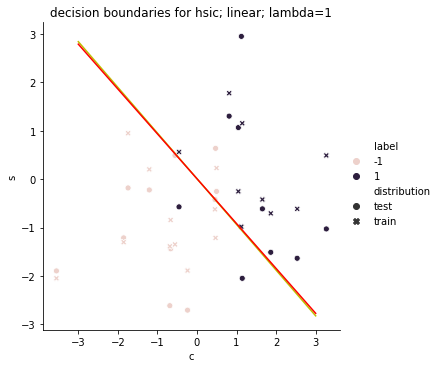

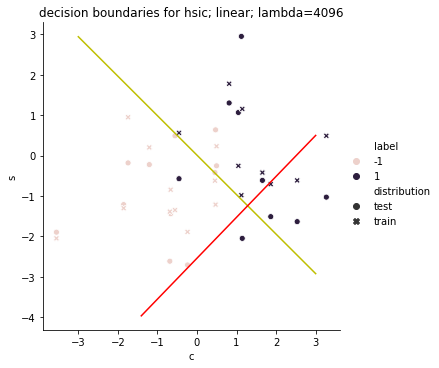

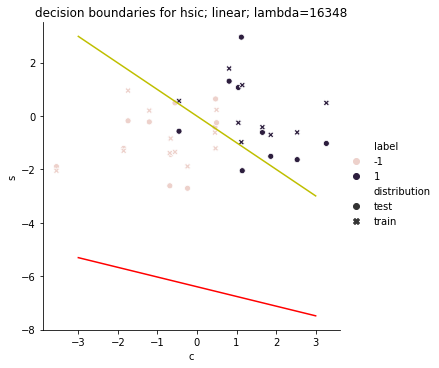

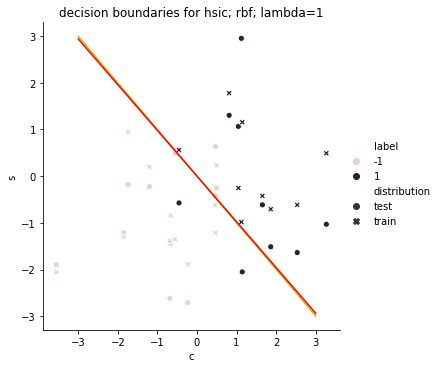

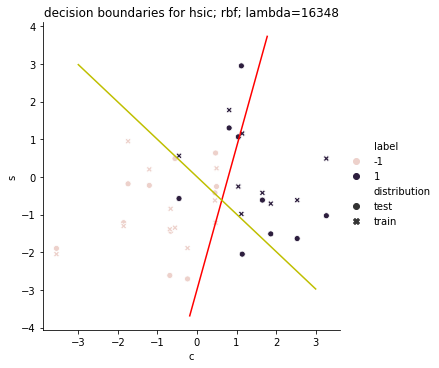

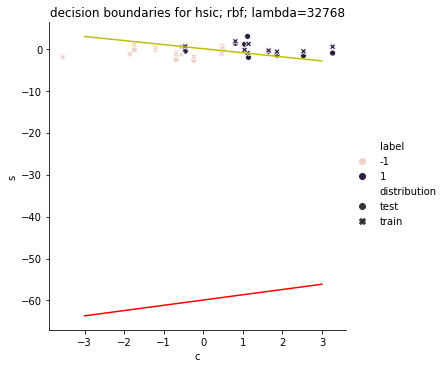

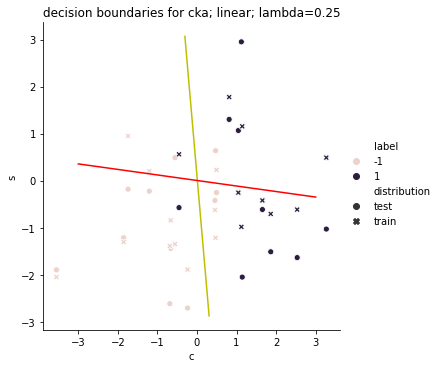

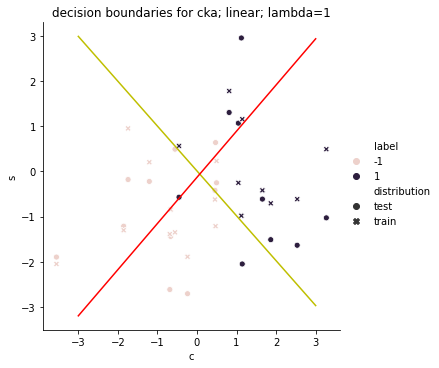

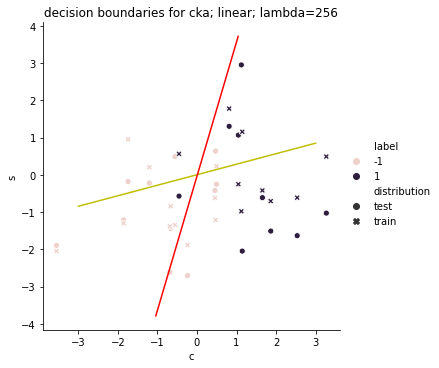

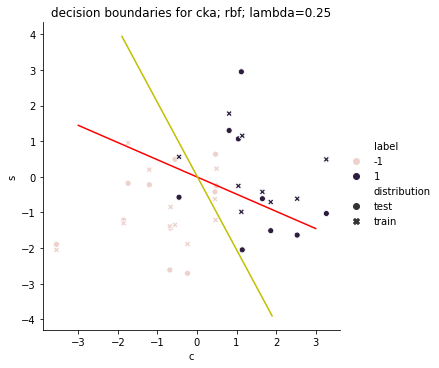

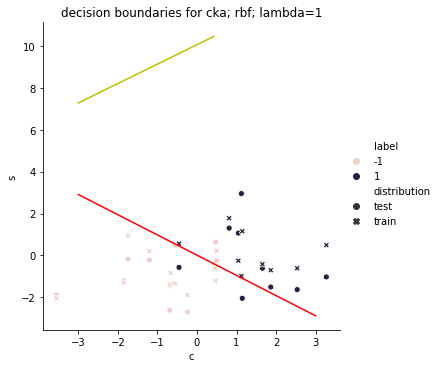

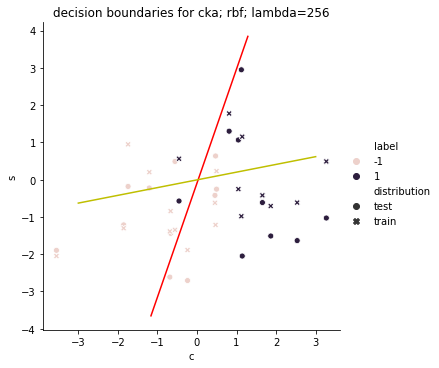

In [347]:
#!/usr/bin/env python3
import seaborn as sns
import concurrent.futures
import argparse
import numpy as np
import subprocess
import os
from pathlib import Path
from typing import List, Optional
import json
import pandas as pd
import matplotlib.pyplot as plt

n_samples = 20

sigma_c = 1.0
sigma_s = 1.0

np.random.seed(0)
y = np.random.choice([1, -1], size=(n_samples))
c = np.random.normal(y, scale=sigma_c, size=(n_samples))
z = np.random.choice([1, -1], size=(n_samples))
s = np.random.normal(z, scale=sigma_s, size=(n_samples))
data = []
for (x_0, x_1, c_y) in zip(c, s, y):
    data.append({
        'c': x_0,
        's': x_1,
        'label': c_y
    })
test_data = pd.DataFrame(data)
test_data['distribution'] = 'test'


np.random.seed(0)
y = np.random.choice([1, -1], size=(n_samples))
c = np.random.normal(y, scale=sigma_c, size=(n_samples))
s = np.random.normal(y, scale=sigma_s, size=(n_samples))
data = []
for (x_0, x_1, c_y) in zip(c, s, y):
    data.append({
        'c': x_0,
        's': x_1,
        'label': c_y
    })
train_data = pd.DataFrame(data)
train_data['distribution'] = 'train'

data = pd.concat([test_data, train_data])
    
xs = np.linspace(-3, 3)


params = []  

for l in [1, 4096, 16348]:
    params.append(('hsic', 'linear', l))
    
for l in [1, 16348, 32768]:
    params.append(('hsic', 'rbf', l))


for l in [1/4, 1, 256]:
    params.append(('cka', 'linear', l))
for l in [1/4, 1, 256]:
    params.append(('cka', 'rbf', l))

def eval_linear_function(a: float, b: float, c: float) -> np.ndarray:
    return - 1 / b * (a * xs + c) 


prob = 'toy'
for indep, k, l in params:
        root = Path(f"{prob}/{indep}/{k}_kernel")
        results = root / f"lambda_{l}" / f"run_1" / "results.json"
        assert results.exists(), f'expected to find {results}!'

        with open(results, "r") as f:
            res = json.load(f)

        net_0 = np.asarray(res["weights"]["0"]['dense/kernel:0'])
        net_0 = net_0 * res["weights"]["0"]["dense_1/kernel:0"][0][0]

        net_1 = np.asarray(res["weights"]["1"]['dense_2/kernel:0'])
        net_1 = net_1 * res["weights"]["1"]["dense_3/kernel:0"][0][0]

        ys_0 = eval_linear_function(a=net_0[0][0], b=net_0[1][0], c=res["weights"]["0"]["dense_1/bias:0"])
        ys_1 = eval_linear_function(a=net_1[0][0], b=net_1[1][0], c=res["weights"]["1"]["dense_3/bias:0"])

        for threshold in [4, 10.5, 100]:
            sel_0 = np.absolute(ys_0) < threshold
            sel_1 = np.absolute(ys_1) < threshold
            
            good = np.sum(sel_0) >= 3 and np.sum(sel_1) >= 3
            if good:
                break
                
        plot = sns.relplot(x='c', y='s', hue='label', style='distribution', legend='full', data=data)

        if ys_0[0] > ys_1[0]:
            plt.plot(xs[sel_0], ys_0[sel_0], 'y-')
            plt.plot(xs[sel_1], ys_1[sel_1], 'r-')
        else:
            plt.plot(xs[sel_0], ys_0[sel_0], 'r-')
            plt.plot(xs[sel_1], ys_1[sel_1], 'y-')

        plot.set(title=f"decision boundaries for {indep}; {k}; lambda={l}")

        plot.savefig(f'decision_boundaries_{indep}_{k}_lambda{l}.png')

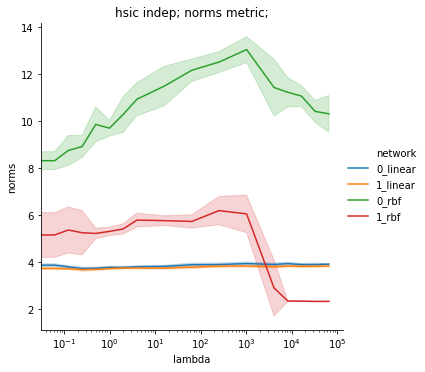

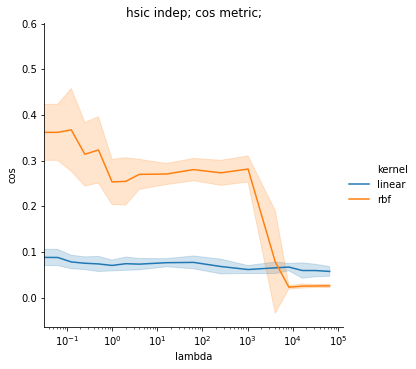

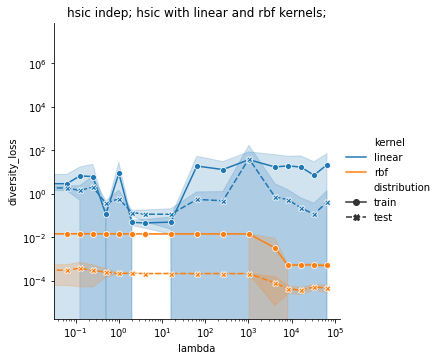

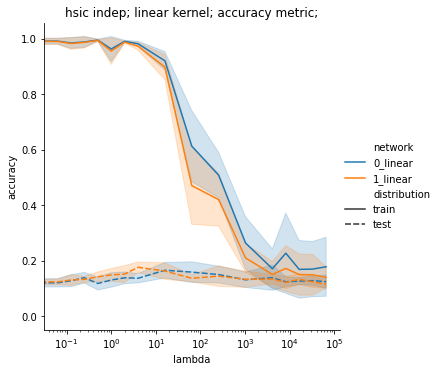

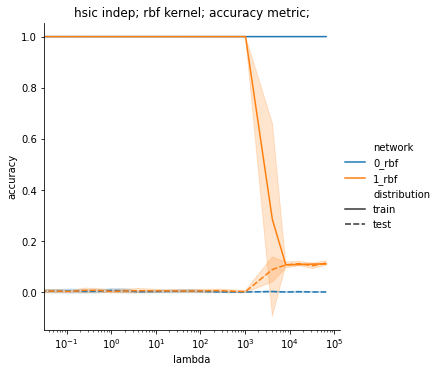

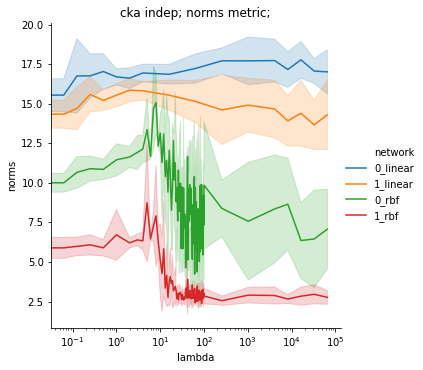

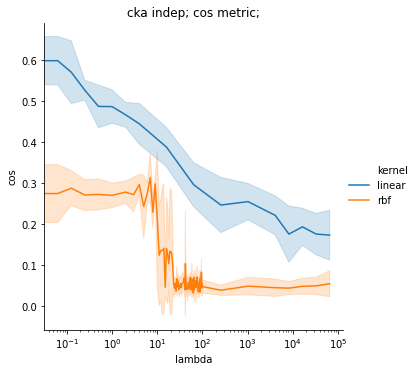

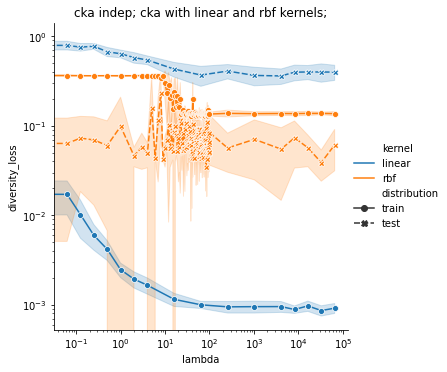

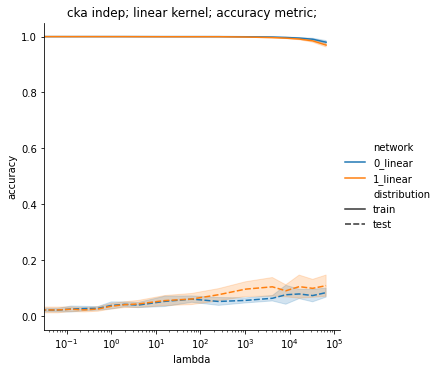

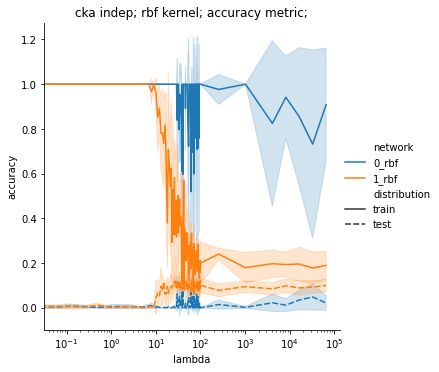

In [365]:
problem = 'biased_mnist'

os.makedirs(f'{problem}/plots', exist_ok=True)

for indep in indep_measures:  
    metric = 'norms'
    df = pd.concat([data_for_kernel(problem, indep, k, metric, swap_by_column='norms') for k in kernels])
    plot = sns.relplot(x="lambda", y=metric, ci="sd", kind="line", hue='network', data=df)
    plot.set(xscale="log")
    plot.set(title=f'{indep} indep; {metric} metric;')
    plot.savefig(f'{problem}/plots/{indep}_{metric}.png')

    
    metric = 'cos'
    df = pd.concat([data_for_kernel(problem, indep, k, metric, swap_by_column='norms') for k in kernels])
    plot = sns.relplot(x="lambda", y=metric, ci="sd", kind="line", hue='kernel', data=df)
    plot.set(xscale="log")
    plot.set(title=f'{indep} indep; {metric} metric;')
    plot.savefig(f'{problem}/plots/{indep}_{metric}.png')
    
    
    dfs = []
    for k in kernels:
        df_train = data_for_kernel(problem, indep, k, 'train_diversity_loss', swap_by_column='norms').rename(columns={'train_diversity_loss': "diversity_loss"})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_diversity_loss', swap_by_column='norms').rename(columns={'test_diversity_loss': f"diversity_loss"})
        df_test['distribution'] = 'test'
        dfs.append(pd.concat([df_train, df_test]))

    df = pd.concat(dfs)
    plot = sns.relplot(x="lambda", y='diversity_loss', ci="sd", kind="line", hue='kernel', style='distribution', markers=True, data=df)
    plot.set(xscale="log")
    plot.set(yscale="log")
    plot.set(title=f'{indep} indep; {indep} with linear and rbf kernels;')
    plot.savefig(f'{problem}/plots/{indep}_diversity.png') 
        
    for k in kernels:
        df_train = data_for_kernel(problem, indep, k, 'train_accuracy', swap_by_column='train_accuracy').rename(columns={'train_accuracy': 'accuracy'})
        df_train['distribution'] = 'train'
        df_test = data_for_kernel(problem, indep, k, 'test_accuracy', swap_by_column='train_accuracy').rename(columns={'test_accuracy': 'accuracy'})
        df_test['distribution'] = 'test'
        df = pd.concat([df_train, df_test])
        plot = sns.relplot(x="lambda", y='accuracy', ci="sd", kind="line", hue='network', style='distribution', data=df)
        plot.set(xscale="log")
        plot.set(title=f'{indep} indep; {k} kernel; accuracy metric;')
        plot.savefig(f'{problem}/plots/{indep}_{k}_accuracy.png') 